In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import enum 
from mpl_toolkits import mplot3d
from scipy.interpolate import RegularGridInterpolator
import warnings

warnings.filterwarnings("ignore")

In [2]:
class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0

def GeneratePathsMerton(NoOfPaths,NoOfSteps,S0, T,xiP,muJ,sigmaJ,r,sigma):    

    # Create empty matrices for Poisson process and for compensated Poisson process

    X = np.zeros([NoOfPaths, NoOfSteps+1])
    S = np.zeros([NoOfPaths, NoOfSteps+1])
    time = np.zeros([NoOfSteps+1])
                
    dt = T / float(NoOfSteps)
    X[:,0] = np.log(S0)
    S[:,0] = S0
    
    # Expectation E(e^J) for J~N(muJ,sigmaJ^2)

    EeJ = np.exp(muJ + 0.5*sigmaJ*sigmaJ)
    ZPois = np.random.poisson(xiP*dt,[NoOfPaths,NoOfSteps])
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    J = np.random.normal(muJ,sigmaJ,[NoOfPaths,NoOfSteps])
    for i in range(0,NoOfSteps):

        # Making sure that samples from a normal have mean 0 and variance 1

        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])

        # Making sure that samples from a normal have mean 0 and variance 1

        X[:,i+1]  = X[:,i] + (r - xiP*(EeJ-1) - 0.5*sigma*sigma)*dt +sigma*np.sqrt(dt)* Z[:,i]\
                    + J[:,i] * ZPois[:,i]
        time[i+1] = time[i] +dt
        
    S = np.exp(X)
    paths = {"time":time,"X":X,"S":S}
    return paths

def GeneratePathsGBM(NoOfPaths,NoOfSteps,T,r,sigma,S_0):    
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    X = np.zeros([NoOfPaths, NoOfSteps+1])
    W = np.zeros([NoOfPaths, NoOfSteps+1])
    time = np.zeros([NoOfSteps+1])
        
    X[:,0] = np.log(S_0)
    
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):

        # Making sure that samples from a normal have mean 0 and variance 1

        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
        W[:,i+1] = W[:,i] + np.power(dt, 0.5)*Z[:,i]
        X[:,i+1] = X[:,i] + (r - 0.5 * sigma * sigma) * dt + sigma * (W[:,i+1]-W[:,i])
        time[i+1] = time[i] +dt
        
    # Compute exponent of ABM

    S = np.exp(X)
    paths = {"time":time,"S":S}
    return paths

# Black-Scholes call option price

def BS_Call_Put_Option_Price(CP,S_0,K,sigma,t,T,r):
    K = np.array(K).reshape([len(K),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) 
    * (T-t)) / (sigma * np.sqrt(T-t))
    d2    = d1 - sigma * np.sqrt(T-t)
    if CP == OptionType.CALL:
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * (T-t))
    elif CP == OptionType.PUT:
        value = st.norm.cdf(-d2) * K * np.exp(-r * (T-t)) - st.norm.cdf(-d1)*S_0
    return value

def BS_Delta(CP,S_0,K,sigma,t,T,r):

    # When defining a time grid it may happen that the last grid point 
    # is slightly behind the maturity time

    if t-T>10e-20 and T-t<10e-7:
        t=T
    K = np.array(K).reshape([len(K),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) * \
             (T-t)) / (sigma * np.sqrt(T-t))
    if CP == OptionType.CALL:
        value = st.norm.cdf(d1)
    elif CP == OptionType.PUT:
       value = st.norm.cdf(d1)-1.0
    return value


def mainCalculation():
    NoOfPaths = 1000
    NoOfSteps = 200
    T         = 1.0
    r         = 0.1
    sigma     = 0.2
    xiP       = 1.0
    muJ       = 0.0
    sigmaJ    = 0.25
    s0        = 1.0
    K         = [0.95]
    CP        = OptionType.CALL
    
    np.random.seed(7)
    Paths = GeneratePathsMerton(NoOfPaths,NoOfSteps,s0, T,xiP,muJ,sigmaJ,r,sigma)
    time  = Paths["time"]
    S     = Paths["S"]
    
    # Setting up some convenient lambdas

    C = lambda t,K,S0: BS_Call_Put_Option_Price(CP,S0,K,sigma,t,T,r)
    Delta = lambda t,K,S0: BS_Delta(CP,S0,K,sigma,t,T,r)
    
    # Setting up initial portfolio

    PnL = np.zeros([NoOfPaths,NoOfSteps+1])
    delta_init= Delta(0.0,K,s0)
    PnL[:,0] = C(0.0,K,s0) - delta_init * s0
            
    CallM      = np.zeros([NoOfPaths,NoOfSteps+1])
    CallM[:,0] = C(0.0,K,s0)
    DeltaM     = np.zeros([NoOfPaths,NoOfSteps+1])
    DeltaM[:,0] = Delta(0,K,s0)
    
    for i in range(1,NoOfSteps+1):
        dt = time[i] - time[i-1]
        delta_old  = Delta(time[i-1],K,S[:,i-1])
        delta_curr = Delta(time[i],K,S[:,i])
        
        PnL[:,i] =  PnL[:,i-1]*np.exp(r*dt) - (delta_curr-delta_old)*S[:,i] # PnL
        CallM[:,i] = C(time[i],K,S[:,i])
        DeltaM[:,i]   =Delta(time[i],K,S[:,i])
    
    # Final transaction, payment of the option (if in the money) and selling the hedge

    PnL[:,-1] = PnL[:,-1] -np.maximum(S[:,-1]-K,0) +  DeltaM[:,-1]*S[:,-1]
    
    # We plot only one path at the time

    path_id = 10
    plt.figure(1)
    plt.plot(time,S[path_id,:])
    plt.plot(time,CallM[path_id,:])
    plt.plot(time,DeltaM[path_id,:])
    plt.plot(time,PnL[path_id,:])
    plt.legend(['Stock','CallPrice','Delta','PnL'])
    plt.grid()
    
    # Plot the histogram of PnL

    plt.figure(2)
    plt.hist(PnL[:,-1],100)
    plt.grid()
    plt.xlim([-0.1,0.1])
    
    # Tabulate result for a given path

    print("path no {0}, S0={1}, PnL(Tm-1)={2}, S(tm)={3}, max(S(Tm)-K,0)={4}, \
          PnL(Tm)={5}".format(path_id,s0,PnL[path_id,-2],S[path_id,-1], np.maximum(S[path_id,-1]-K,0.0),PnL[path_id,-1]))


path no 10, S0=1.0, PnL(Tm-1)=-1.1252845481150666, S(tm)=1.2908416131418075, max(S(Tm)-K,0)=[0.34084161],           PnL(Tm)=-0.175847331073139


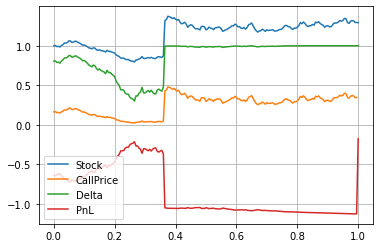

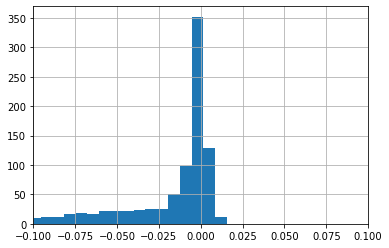

In [3]:
mainCalculation()